## Multi-class classification example

In this example we show how the ecgxai package can be used to easily build a classification system for multiple classes (in this case for Sinus Rhythm (NSR), Sinus Arrhythmia (SA), Sinus Bradycardia (SB) and Sinus tachycardia (STach)). We train the model on the PTB-XL dataset and use 'double residual' convolution resnet architecture. 

In [8]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install torch==2.7.0 torchvision torchaudio torchmetrics torchinfo scipy scikit-learn pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [10]:
import torch
print(torch.__version__)

2.7.0+cpu


In [11]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [12]:
import sys
import os

# Lấy thư mục làm việc hiện tại
current_dir = os.getcwd()

# Lấy thư mục cha (root project)
root_dir = os.path.abspath(os.path.join(current_dir, '../..'))
print("Root project directory:", root_dir)

if root_dir not in sys.path:
    sys.path.insert(0, root_dir)

Root project directory: c:\Users\admin\Desktop\ecgxai\ecgxai


In [13]:
%load_ext autoreload
%autoreload 2
# We first import the required data utilities from the ecgxai package
from ecgxai.utils.dataset import PTBXLDataset
from ecgxai.utils.transforms import ApplyGain, ToTensor

# We also import some additional utilities from other packages for additionally functionality
from torch.utils.data import DataLoader
from torchvision.transforms import Compose

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# The PTBXL dataset class automatically downloads and extract the PTB-XL 12 lead dataset
dataset = PTBXLDataset(
    # The p                                        ath parameter defines where the data should be stored and were the data can be found in the future
    path=r"C:\Users\admin\Desktop\ecgxai\ecgxai\WFDB_PTBXL\PTB_XL", 
    # We use the ApplyGain and ToTensor transformation (chained through the compose class)
    # to format the data into the desired format. In the case of PTB-XL, all the input data
    # is devided by 1000 in the ApplyGain transform to smoothen training (see the next cell for an example).
    transform = Compose([ApplyGain(), ToTensor()]),
    # The use_numpy parameter is set to True to speed up the loading of the data
    use_numpy=True,
    # As we are classifying Sinus Rhythm (NSR), Sinus Arrhythmia (SA), Sinus Bradycardia (SB) and Sinus tachycardia (STach) 
    # in this example we tell the dataset to use the 'NSR' 'SA', 'SB' and 'STach' labels. 
    labels=['NSR', 'SA', 'SB', 'STach']
)

100%|██████████| 21837/21837 [00:00<00:00, 29509.30it/s]


In [15]:
# We then randomly split the dataset into a train and test set using a 90%-10% split
trainset, testset = dataset.train_test_split(ratio=0.1, shuffle=True)

print("Trainset:")
trainset.print_stats()

print("\n Testset: ")
testset.print_stats()

Trainset:
-- Dataset distribution -- 
Full size: 19653
["NSR"] - Num entries: 16287 (82.9%)
["SA"] - Num entries: 681 (3.47%)
["SB"] - Num entries: 573 (2.92%)
["STach"] - Num entries: 747 (3.8%)

 Testset: 
-- Dataset distribution -- 
Full size: 2184
["NSR"] - Num entries: 1805 (82.6%)
["SA"] - Num entries: 91 (4.17%)
["SB"] - Num entries: 64 (2.93%)
["STach"] - Num entries: 79 (3.62%)


In [16]:
# The train and testset are then supplied to a pytorch dataloader which we can use to train the model
train_loader = DataLoader(
        trainset,
        batch_size=64,
        num_workers=8,
        shuffle=True
)

test_loader = DataLoader(
    testset,
    batch_size=64,
    num_workers=8
)

### Checking the data

The cell below plots the first lead of a sample from the dataset which we get using the __\_\_getitem\_\_()__ function which returns a dictionary. The raw ecg is stored under the 'waveform' key. 

dict_keys(['waveform', 'samplebase', 'gain', 'id', 'truebaseline_0', 'truebaseline_1', 'truebaseline_2', 'truebaseline_3', 'truebaseline_4', 'truebaseline_5', 'truebaseline_6', 'truebaseline_7', 'truebaseline_8', 'truebaseline_9', 'truebaseline_10', 'truebaseline_11', 'label'])


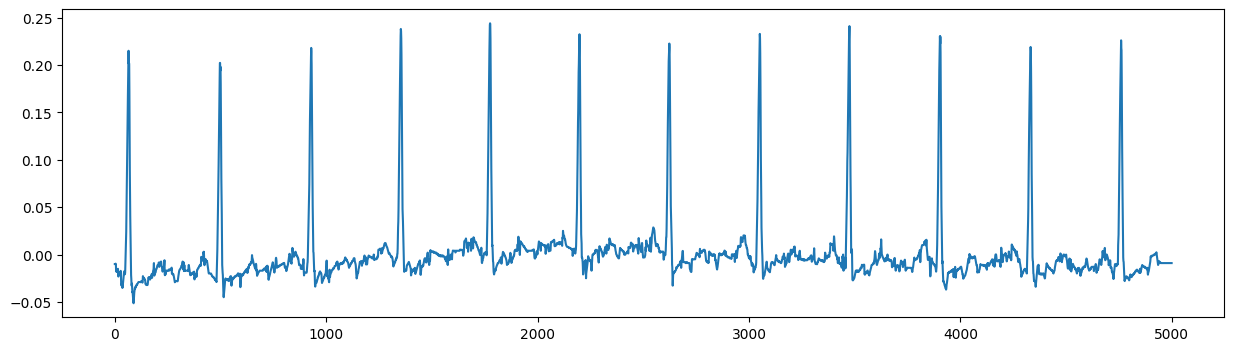

In [17]:
import matplotlib.pyplot as plt

example = trainset.__getitem__(0)

# We can plot the keys of the dictionary to see what is available in the standard dataset configuration. The 'truebaseline' 
# keys are used for baseline correction in some datasets. 
print(example.keys())

plt.figure(figsize=(15, 4))
plt.plot(example['waveform'][0])

### Initializing the model

We import the CNNDoubleResidual architecture from the ecgxai package and pass it the required hyperparameters to deal with our dataset (e.g. 12 channels, 5000 measurements per lead). We choose to subsample (half the spatial dimension) each layer to limit the required number of parameters. 

We also define adittional Sequential and Linear layer to map the CNN output to the desired 2 classes

In [18]:
pip install pytorch-lightning==2.4.0

Note: you may need to restart the kernel to use updated packages.


In [19]:
import pytorch_lightning

print(pytorch_lightning.__version__)

2.4.0


In [20]:
import torch.nn as nn
from ecgxai.network.doubleresidual.modules import CNNDoubleResidual, Reshape

# Initualize the double reisdual convolutional resnet
cnn = CNNDoubleResidual(
    num_layers=10,
    in_sample_dim=5000,
    in_channels=12,
    kernel_size=7,
    dropout_rate=0.1,
    sub_sample_every=1,
    double_channel_every=4,
    act_func=nn.ReLU(),
    batchnorm=True
)

# use the calculate_output_dim to see what size the output of the CNN is
cnn_output_dim, cnn_output_channels, cnn_output_samples = cnn.calculate_output_dim()

# We pass this calculated size to a linear layer that then maps the data to 4 outputs per ecg
class_model = nn.Sequential(
    cnn,
    nn.Linear(cnn_output_dim, 4),
)

In [21]:
from torchinfo import summary

batch_size = 16
summary(class_model, input_size=(1, 12, 5000), depth=50)

Layer (type:depth-idx)                                       Output Shape              Param #
Sequential                                                   [1, 4]                    --
├─CNNDoubleResidual: 1-1                                     [1, 432]                  --
│    └─Sequential: 2-1                                       [1, 432]                  --
│    │    └─ResidualMaxPoolDoubleConvBlockForward: 3-1       [1, 12, 5000]             2,088
│    │    │    └─MaxPool1d: 4-1                              [1, 12, 5000]             --
│    │    │    └─Sequential: 4-4                             --                        (recursive)
│    │    │    │    └─BatchNorm1d: 5-1                       [1, 12, 5000]             24
│    │    └─ResidualMaxPoolDoubleConvBlockForward: 3-26      --                        (recursive)
│    │    │    └─Sequential: 4-38                            --                        (recursive)
│    │    │    │    └─ReLU: 5-2                              [1, 

In [22]:
%load_ext autoreload
%autoreload 2
from ecgxai.systems.classification_system import ClassificationSystem
from ecgxai.utils.loss import TW
from ecgxai.utils.metrics import TMW

from torchmetrics import MetricCollection, AUROC, F1Score, Accuracy, Precision, Recall

metrics = {
   'AUROC':  TMW(
       AUROC(task="multiclass", num_classes=4, average=None),
       ['y_prob', 'label'],
       int_args=['label'], 
       out_labels=['NSR', 'SA', 'SB', 'STach']
   ),
   'Precision': TMW(
       Precision(task='multiclass', num_classes=4, average=None),
       ['y_prob', 'label'],
       int_args=['label'],
       out_labels=['NSR', 'SA', 'SB', 'STach']
   ),
   'Recall': TMW(
       Recall(task='multiclass', num_classes=4, average=None),
       ['y_prob', 'label'],
       int_args=['label'],
       out_labels=['NSR', 'SA', 'SB', 'STach']
   ),
   'Accuracy': TMW(
       Accuracy(task='multiclass', num_classes=4, average=None),
       ['y_prob', 'label'],
       int_args=['label'],
       out_labels=['NSR', 'SA', 'SB', 'STach']
   ),
   'F1': TMW(
       F1Score(task='multiclass', num_classes=4, average=None),
       ['y_prob', 'label'],
       int_args=['label'],
       out_labels=['NSR', 'SA', 'SB', 'STach']
   )
} 

metrics = MetricCollection(metrics)
    
model = ClassificationSystem(
    lr=0.001,
    mode='multi_class',
    model=class_model,
    test_metrics=metrics,
    loss=TW(nn.CrossEntropyLoss(), ['y_hat', 'label'], long_args=['label'], arg_max_args=['label'])
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['y_hat', 'label']


c:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (TMW). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower be

In [23]:
pip install tensorboardX

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install tensorboard

Note: you may need to restart the kernel to use updated packages.


In [25]:
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger("tb_logs", name="my_model")

trainer = pl.Trainer(
        max_epochs=10,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        logger=logger,
        callbacks=[
            ModelCheckpoint(
                save_last=True
            ),
        ]
    )

trainer.fit(model, train_dataloaders=train_loader)
trainer.test(model=model, dataloaders=test_loader)

print("Done")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | test_metrics | MetricCollection | 0      | train
1 | loss         | TW               | 0      | train
2 | prob_func    | Softmax          | 0      | train
3 | model        | Sequential       | 128 K  | train
----------------------------------------------------------
128 K     Trainable params
0         Non-trainable params
128 K     Total params
0.515     Total estimated model params size (MB)
140       Modules in train mode
0         Modules in eval mode
c:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\core\saving.

Epoch 9: 100%|██████████| 308/308 [01:49<00:00,  2.81it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 308/308 [01:49<00:00,  2.81it/s, v_num=1]


c:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0:   3%|▎         | 1/35 [00:00<00:06,  5.16it/s]

c:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Testing DataLoader 0:  14%|█▍        | 5/35 [00:00<00:04,  6.40it/s]

c:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Testing DataLoader 0: 100%|██████████| 35/35 [00:03<00:00,  9.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_NSR            0.9898340702056885
         test_SA                    0.0
         test_SB            0.22876298427581787
       test_STach           0.5421181917190552
        test_loss           0.21130917966365814
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


c:\Users\admin\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\utilities\data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Done
